# prepare

48
CPU Usage: 73.9%
13
now using: 2
Sun Jan 21 23:02:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.146.02             Driver Version: 535.146.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:52:00.0 Off |                  Off |
| 53%   61C    P2             228W / 450W |  16905MiB / 24564MiB |     59%      Default |
|                                         |                      |                  N/A |
+-------------------------------

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
<class 'monai.transforms.utility.dictionary.AddChanneld'>: Class `AddChanneld` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead with `channel_dim='no_channel'`.
monai.transforms.utility.dictionary EnsureChannelFirstd.__init__:meta_keys: Argument `meta_keys` has been deprecated since version 0.9. not needed if image is type `MetaTensor`.


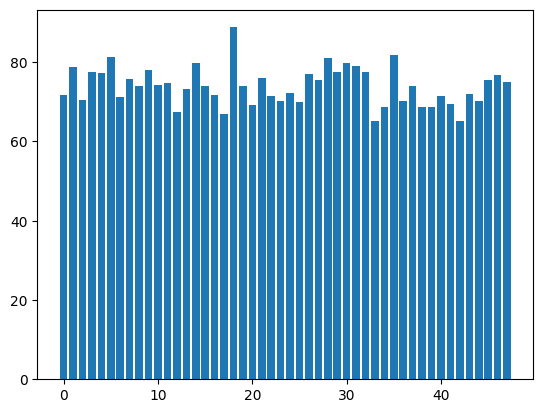

In [1]:
import psutil

# Get CPU usage per core
cpu_usage_per_core = psutil.cpu_percent(percpu=True)
print(len(cpu_usage_per_core))

# Get CPU usage as a percentage
cpu_usage = psutil.cpu_percent()
print(f"CPU Usage: {cpu_usage}%")


import matplotlib.pyplot as plt
plt.bar(range(len(cpu_usage_per_core)), cpu_usage_per_core)

WORKERS=len(cpu_usage_per_core)-int((len(cpu_usage_per_core)*cpu_usage/100))
print(WORKERS)

import GPUtil
import os

# Get all available GPUs and their memory usage
gpus = GPUtil.getGPUs()

# Find the GPU with the most available memory
most_free_gpu = None
for gpu in gpus:
    if most_free_gpu is None or gpu.memoryFree > most_free_gpu.memoryFree:
        most_free_gpu = gpu
        
print("now using:",most_free_gpu.id)
# Set the CUDA_VISIBLE_DEVICES environment variable to the index of the chosen GPU
os.environ["CUDA_VISIBLE_DEVICES"] = str(most_free_gpu.id)

random_seed=42
!nvidia-smi

import pandas as pd
df=pd.read_csv('seed_nc_list.csv')
seed_nc_list=df['seed_nc'].values
seed_nc_prob_list=df['seed_nc_prob'].values
iter_seed=iter(seed_nc_list)

import os
import tempfile
import time
import SimpleITK as sitk

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.transforms import AddChanneld, CenterSpatialCropd, Compose, Lambdad, LoadImaged, Resized, ScaleIntensityd
from monai.utils import set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler, DDIMScheduler
print_config()

import time
# save time
train_start_time=time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())
#save_dir=os.path.join("/root/ddpm_tmp",train_start_time)
# check dir exists

channel=64
batch_size=1
image_size=(72, 96, 72)
QUCIK_CHECK=False
ADNI_QUICK_CHECK=True
n_epochs = 75
val_interval = 25
epoch_loss_list = []
val_epoch_loss_list = []

directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

set_determinism(42)


data_transform =Compose(
    [
        LoadImaged(keys=["image"]),
        Lambdad(keys="image", func=lambda x: x[:, :, :, 1]),
        AddChanneld(keys=["image"]),
        ScaleIntensityd(keys=["image"]),
        CenterSpatialCropd(keys=["image"], roi_size=[160, 200, 155]),
        Resized(keys=["image"], spatial_size=(32, 40, 32)),
    ]
)

if QUCIK_CHECK:
    # generate pseudo torch data for quick check
    train_ds=[{"image":torch.randn(1,32,40,32) for _ in range(10)}]
    val_ds=[{"image":torch.randn(1,32,40,32) for _ in range(10)}]
    train_loader=DataLoader(train_ds, batch_size=4, shuffle=True)
    val_loader=DataLoader(val_ds, batch_size=4, shuffle=False)

    train_ds=[{"image":torch.randn(1,*image_size) for _ in range(10)}]
    val_ds=[{"image":torch.randn(1,*image_size) for _ in range(10)}]
    train_loader=DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader=DataLoader(val_ds, batch_size=batch_size, shuffle=False)

if ADNI_QUICK_CHECK:
    from torch.utils.data import Dataset, DataLoader, IterableDataset
    from scipy.io import loadmat
    base_line_dir = 'ADNI1+2_baseline'

    import pandas as pd
    def get_adni_from_csv(csv_file):
        # Load csv_file
        df = pd.read_csv(csv_file)
        # Remove duplicate file with subject id
        df = df.drop_duplicates(subset=['Subject'])
        # Remove subject when the Group is not AD or CN
        df = df[df['Group'].isin(['AD', 'CN'])]
        # Remove subject except the MRI/subject_id.mat and PET/subject_id.mat exist
        subject_ids = df['Subject'].tolist()
        mri_files = [base_line_dir + f'/MRI/{subject_id}.mat' for subject_id in subject_ids]
        mri_files_exist = [os.path.exists(file) for file in mri_files]
        df = df[mri_files_exist]
        # Map Group string to Label int
        df['Label'] = df['Group'].map({'CN': 1, 'AD': 2})
        # 15% map label to -1 for unconditional training of DDPM
        '''def map_50_fn(x):
            if np.random.rand() < 0.5:
                return -1
            else:
                return x
        df['Label'] = df['Label'].map(map_50_fn)
        '''

        # shuffle in df
        df = df.sample(frac=1,random_state=42).reset_index(drop=True)
        return df

    train_df = get_adni_from_csv(base_line_dir + '/ADNI1_imdb_36m.csv')
    test_df = get_adni_from_csv(base_line_dir + '/ADNI2_imdb_36m.csv')

class adni_dataset(IterableDataset):
    def __init__(self, df):
        self.df = df
        self.subject_ids = df['Subject'].tolist()
        self.labels = df['Label'].tolist()

    def __len__(self):
        return len(self.subject_ids)

    def __iter__(self):
        for i in range(len(self.subject_ids)):
            subject_id = self.subject_ids[i]
            label = self.labels[i]
            mri_file = base_line_dir + f'/MRI/{subject_id}.mat'
            mri = loadmat(mri_file)['IMG']  # 181,217,181
            # 181,217,181 // 32 = 5,6,5 * 32= 160,192,160 /2 = 80,96,80
            # center_crop to 160,192,160
            # 10,11, 10,15,10,11
            mri = mri[10:170, 10:202, 10:170]
            mri = mri / np.max(mri)
            # downsamle
            mri = mri[::2, ::2, ::2]  # 80,96,80
            # to torch
            mri = torch.from_numpy(mri).unsqueeze(0).float()
            # randomly maps label to -1 with 15% probability
            '''if np.random.rand() < 0.15:
                label = -1''' # should map to -1 only in df not here
            yield {'image':mri,'class':label,'subject_id':subject_id}

if QUCIK_CHECK:
    # sample top 20 to check coding right
    train_df=train_df[:20]
    test_df=test_df[:20]
train_ds = adni_dataset(train_df)
val_ds = adni_dataset(test_df)
train_loader = DataLoader(train_ds, batch_size=batch_size,num_workers=0)
val_loader = DataLoader(val_ds, batch_size=batch_size,num_workers=0)


print(next(iter(train_loader))['image'].shape)

device = torch.device("cuda:0")

model = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=[channel,channel,channel*2],
    attention_levels=[False, False, True],
    num_head_channels=[0, 0, channel*2],
    num_res_blocks=2,
    with_conditioning=True, # modified based on liu_monai_ddpm
    cross_attention_dim=1, # modified based on liu_monai_ddpm
)

model.eval()
model.to(device)

scheduler = DDIMScheduler(num_train_timesteps=1000, 
                          #beta_schedule="scaled_linear", 
                          beta_start=0.0005, beta_end=0.0195)
inferer = DiffusionInferer(scheduler)
optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5)

scaler = GradScaler()
total_start = time.time()

Train=False
if Train:
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in progress_bar:
            images = batch["image"].to(device)
            # modified based on liu_monai_ddpm
            classes = batch["class"].to(device).float().unsqueeze(0).unsqueeze(0)
            optimizer.zero_grad(set_to_none=True)

            with autocast(enabled=True):
                # Generate random noise
                noise = torch.randn_like(images).to(device)
                # Create timesteps
                timesteps = torch.randint(
                    0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                ).long()
                # Get model prediction
                #print(images.shape,noise.shape,timesteps.shape)
                noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps,
                                     condition=classes,         # modified based on liu_monai_ddpm
                                     )
                loss = F.mse_loss(noise_pred.float(), noise.float())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item()
            progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
        epoch_loss_list.append(epoch_loss / (step + 1))


    torch.save(model.state_dict(), save_dir + "/model.pt")
    total_time = time.time() - total_start
    print(f"train completed, total time: {total_time}.")

    plt.style.use("seaborn-v0_8")
    plt.title("Learning Curves", fontsize=20)
    plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.legend(prop={"size": 14})
    plt.savefig(save_dir+"/learning_curve.png")

else:
    #model.load_state_dict(torch.load('/home/liushiyu/temp/liu_monai_conditoned_ddpm/2023_05_08_15_00_57/model.pt'))
    #model.load_state_dict(torch.load('/home/liushiyu/temp/liu_monai_ddpm/2023_05_09_13_47_45/model.pt'))
    #model.load_state_dict(torch.load('/home/liushiyu/temp/model.pt')) # condition cn ad = 0 1
    model.load_state_dict(torch.load('model_cond_1_2.pt')) # condition cn ad = 1 2
    save_dir="/home/liushiyu/temp/saved"
    
import logging
import os
import sys
import shutil
import tempfile
import matplotlib.pyplot as plt
import torch
import numpy as np
import monai
from monai.config import print_config
from torch.utils.data import Dataset, DataLoader, IterableDataset
from scipy.io import loadmat
import pandas as pd

cls_model= monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)
cls_model.load_state_dict(torch.load("best_metric_model_classification3d_array_old.pth"))


def compare_3d(image_list):
    def show_3d(image):
        plotting_image_0 = np.concatenate([image[0, 0, :, :, 40].cpu(), np.flipud(image[0, 0, :, 48, :].cpu())], axis=1)
        plotting_image_1 = np.concatenate([np.flipud(image[0, 0, 40, :, :].cpu()), np.zeros((96, 96))], axis=1)
        return np.concatenate([plotting_image_0, plotting_image_1],axis=0).T
    plt.imshow(np.concatenate([show_3d(image) for image in image_list], axis=1), 
               vmin=0, vmax=1, 
               cmap="gray")

def compare_3d_jet(image_list):
    def show_3d(image):
        plotting_image_0 = np.concatenate([image[0, 0, :, :, 40].cpu(), np.flipud(image[0, 0, :, 48, :].cpu())], axis=1)
        plotting_image_1 = np.concatenate([np.flipud(image[0, 0, 40, :, :].cpu()), np.zeros((96, 96))], axis=1)
        return np.concatenate([plotting_image_0, plotting_image_1],axis=0).T
    plt.imshow(np.concatenate([show_3d(image) for image in image_list], axis=1),cmap='jet')
    
def compare_3d_no_clip(image_list):
    def show_3d(image):
        plotting_image_0 = np.concatenate([image[0, 0, :, :, 40].cpu(), np.flipud(image[0, 0, :, 48, :].cpu())], axis=1)
        plotting_image_1 = np.concatenate([np.flipud(image[0, 0, 40, :, :].cpu()), np.zeros((96, 96))], axis=1)
        return np.concatenate([plotting_image_0, plotting_image_1],axis=0).T
    plt.imshow(np.concatenate([show_3d(image) for image in image_list], axis=1), 
               cmap="gray")
def compare_3d(image_list,title='.'):
    def show_3d(image):
        if isinstance(image, np.ndarray):
            image=torch.tensor(image)
        if image.dim()==3:
            image=image.unsqueeze(0).unsqueeze(0)
        elif image.dim()==4:
            image=image.unsqueeze(0)
        _,_,h,w,d=image.shape
        plotting_image_0 = np.concatenate([image[0, 0, :, :, d//2].cpu(), np.fliplr(image[0, 0, :, w//2, :].cpu())], axis=1)
        plotting_image_1 = np.concatenate([np.fliplr(image[0, 0, h//2, :, :].cpu()), np.zeros((w, w))], axis=1)
        return np.concatenate([plotting_image_0, plotting_image_1],axis=0).T
    plt.figure(figsize=(20*len(image_list),20),dpi=50)
    plt.grid(False)
    plt.title(title)
    plt.imshow(np.concatenate([show_3d(image) for image in image_list], axis=1), 
               #vmin=0, vmax=1, 
               cmap="gray")
def compare_3d_jet(image_list,title='.'):
    def show_3d(image):
        _,_,h,w,d=image.shape
        plotting_image_0 = np.concatenate([image[0, 0, :, :, d//2].cpu(), np.fliplr(image[0, 0, :, w//2, :].cpu())], axis=1)
        plotting_image_1 = np.concatenate([np.fliplr(image[0, 0, h//2, :, :].cpu()), np.zeros((w, w))], axis=1)
        return np.concatenate([plotting_image_0, plotting_image_1],axis=0).T
    plt.figure(figsize=(20*len(image_list),20),dpi=50)
    plt.grid(False)
    plt.title(title)
    plt.imshow(np.concatenate([show_3d(image) for image in image_list], axis=1), 
               vmin=0, vmax=100, 
               cmap="gray")

    #
from generative.metrics import FIDMetric,MMDMetric

def show_no_ref_cfg(y,guidance_scale=3):
    current_img = torch.randn((1,1,80,96,80)).to(device)
    scheduler = DDIMScheduler(num_train_timesteps=1000, beta_start=0.0005, beta_end=0.0195)
    scheduler.set_timesteps(num_inference_steps=50)
    progress_bar=tqdm(scheduler.timesteps)
    context=torch.cat([-1* torch.ones((1,1,1)).to(device),y* torch.ones((1,1,1)).to(device)],dim=0)
    for t in progress_bar:  # go through the noising process
        with autocast(enabled=False):
            with torch.no_grad():
                inputs=torch.cat([current_img]*2)
                model_output = model_old(inputs, 
                                     timesteps=torch.Tensor((t,)).long().to(current_img.device),
                                     context=context,
                                    )
                noise_uc,noise_c=model_output.chunk(2)
                noise_pred = noise_uc + guidance_scale * (noise_c - noise_uc)
                
        current_img, _ = scheduler.step(noise_pred, t, current_img)
    return current_img

def show_ref_cfg(img,y=1,guidance_scale=3,style_cfg=0.5): 
    current_img = torch.randn((1,1,80,96,80)).to(device)
    scheduler = DDIMScheduler(num_train_timesteps=1000, beta_start=0.0005, beta_end=0.0195)
    scheduler.set_timesteps(num_inference_steps=50)
    progress_bar=tqdm(scheduler.timesteps)
    context=torch.cat([-1* torch.ones((1,1,1)).to(device),y* torch.ones((1,1,1)).to(device)],dim=0)
    
    model=get_model_by_factor(style_cfg)
    
    for t in progress_bar:  # go through the noising process
        with autocast(enabled=False):
            with torch.no_grad():
                inputs=torch.cat([current_img]*2)
                model_output = model(inputs, 
                                     timesteps=torch.Tensor((t,)).long().to(current_img.device),
                                     context=context,
                                     ref_x=torch.cat([img]*2).to(device)
                                    )
                noise_uc,noise_c=model_output.chunk(2)
                noise_pred = noise_uc + guidance_scale * (noise_c - noise_uc)
                
        current_img, _ = scheduler.step(noise_pred, t, current_img)
    return current_img

def normalized_cross_correlation(image1, image2):
    mean_image1 = torch.mean(image1)
    mean_image2 = torch.mean(image2)
    
    centered_image1 = image1 - mean_image1
    centered_image2 = image2 - mean_image2
    
    numerator = torch.sum(centered_image1 * centered_image2)
    denominator = torch.sqrt(torch.sum(centered_image1 ** 2) * torch.sum(centered_image2 ** 2))
    
    ncc_score = numerator / denominator
    return ncc_score

model_dir='model.pt_v_1_1_2_1.pth' # best 1/2/-1 cond-diff

#model_dir='model.pt_v_1_2_1_2.pth' # best 1/2/3/-1 cond-diff # noisy
#model_dir='model.pt_v_1_2_1.pth' # best 1/2/3/-1 cond-diff # noisy
#model_dir='model.pt_v_1_2_0.pth' # best 1/2/3/-1 cond-diff

stop_t=-1
Mode='Write'
style_cfg=1.0
current_uc_indices=[0]

from generative.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator,ControlNet
channel=64
model_old = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=[channel,channel,channel*2],
    attention_levels=[False, False, True],
    num_head_channels=[0, 0, channel*2],
    num_res_blocks=2,
    with_conditioning=True, # modified based on liu_monai_ddpm
    cross_attention_dim=1, # modified based on liu_monai_ddpm
).to(device)
model_old.load_state_dict(torch.load(model_dir))

from generative.networks.nets.diffusion_model_unet import BasicTransformerBlock
def torch_dfs(model):
    all_modules = []
    for module in model.modules():
        all_modules.append(module)
    return all_modules


def hacked_basic_transformer_inner_forward(self, x, context=None):
    x_norm1 = self.norm1(x)
    self_attn1 = None

    # Use self-attention
    self_attention_context = x_norm1
    if Mode=='Write':
        self.bank.append(self_attention_context.detach().clone())
    if Mode=='READ':
        if len(self.bank) > 0:
            self_attn1_uc = self.attn1(x_norm1, context=torch.cat([self_attention_context] + self.bank, dim=1))
            self_attn1_c = self_attn1_uc.clone()
            self_attn1_c[current_uc_indices] = self.attn1(
                x_norm1[current_uc_indices],
                context=self_attention_context[current_uc_indices])
            self_attn1 = style_cfg * self_attn1_c + (1.0 - style_cfg) * self_attn1_uc
        self.bank = []
        self.style_cfgs = []
    if self_attn1 is None:
        self_attn1 = self.attn1(x_norm1, context=self_attention_context)

    x = self_attn1.to(x.dtype) + x
    x = self.attn2(self.norm2(x), context=context) + x
    x = self.ff(self.norm3(x)) + x
    return x
 
from typing import Union

def custom_forward(
    self,
    x: torch.Tensor,
    timesteps: torch.Tensor,
    ref_x: torch.Tensor,
    context: Union[torch.Tensor, None] = None,
    class_labels: Union[torch.Tensor, None] = None,
    down_block_additional_residuals: Union[tuple[torch.Tensor], None] = None,
    mid_block_additional_residual: Union[torch.Tensor, None] = None):
    
    for module in attn_modules:
        module.bank = []
    ref_xt = scheduler.add_noise(
        original_samples=ref_x, noise=torch.randn_like(ref_x).to(ref_x.device), timesteps=timesteps
    )
    global Mode
    if timesteps>stop_t:
        Mode='Write'
        self.original_forward(x=ref_xt,timesteps=timesteps,context=context)
    Mode='Read'
    return self.original_forward(x=x,timesteps=timesteps,context=context)


model = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=[channel,channel,channel*2],
    attention_levels=[False, False, True],
    num_head_channels=[0, 0, channel*2],
    num_res_blocks=2,
    with_conditioning=True, # modified based on liu_monai_ddpm
    cross_attention_dim=1, # modified based on liu_monai_ddpm
).to(device)
model.load_state_dict(torch.load(model_dir))

all_modules=torch_dfs(model)
attn_modules = [module for module in all_modules if isinstance(module, BasicTransformerBlock)]

for i, module in enumerate(attn_modules):
    if getattr(module, '_original_inner_forward', None) is None:
        module._original_inner_forward = module.forward
    module.forward = hacked_basic_transformer_inner_forward.__get__(module, BasicTransformerBlock)
    module.bank = []
    module.style_cfgs = []
    module.attn_weight = float(i) / float(len(attn_modules))

model.original_forward=model.forward
model.forward=custom_forward.__get__(model)

def get_model_by_factor(style_cfg=0.5,stop_t=-1,weight=1.0):
    def hacked_basic_transformer_inner_forward(self, x, context=None):
        x_norm1 = self.norm1(x)
        self_attn1 = None

        # Use self-attention
        self_attention_context = x_norm1
        if Mode=='Write':
            if weight>self.attn_weight:
                self.bank.append(self_attention_context.detach().clone())
        if Mode=='READ':
            if len(self.bank) > 0:
                self_attn1_uc = self.attn1(x_norm1, context=torch.cat([self_attention_context] + self.bank, dim=1))
                self_attn1_c = self_attn1_uc.clone()
                self_attn1_c[current_uc_indices] = self.attn1(
                    x_norm1[current_uc_indices],
                    context=self_attention_context[current_uc_indices])
                self_attn1 = style_cfg * self_attn1_c + (1.0 - style_cfg) * self_attn1_uc
            self.bank = []
            self.style_cfgs = []
        if self_attn1 is None:
            self_attn1 = self.attn1(x_norm1, context=self_attention_context)

        x = self_attn1.to(x.dtype) + x
        x = self.attn2(self.norm2(x), context=context) + x
        x = self.ff(self.norm3(x)) + x
        return x

    from typing import Union

    def custom_forward(
        self,
        x: torch.Tensor,
        timesteps: torch.Tensor,
        ref_x: torch.Tensor,
        context: Union[torch.Tensor, None] = None,
        class_labels: Union[torch.Tensor, None] = None,
        down_block_additional_residuals: Union[tuple[torch.Tensor], None] = None,
        mid_block_additional_residual: Union[torch.Tensor, None] = None):

        for module in attn_modules:
            module.bank = []
        ref_xt = scheduler.add_noise(
            original_samples=ref_x, noise=torch.randn_like(ref_x).to(ref_x.device), timesteps=timesteps
        )
        global Mode
        if timesteps>stop_t:
            Mode='Write'
            self.original_forward(x=ref_xt,timesteps=timesteps,context=context)
        Mode='Read'
        return self.original_forward(x=x,timesteps=timesteps,context=context)
    
    model = DiffusionModelUNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=1,
        num_channels=[channel,channel,channel*2],
        attention_levels=[False, False, True],
        num_head_channels=[0, 0, channel*2],
        num_res_blocks=2,
        with_conditioning=True, # modified based on liu_monai_ddpm
        cross_attention_dim=1, # modified based on liu_monai_ddpm
    ).to(device)
    model.load_state_dict(torch.load(model_dir))

    all_modules=torch_dfs(model)
    attn_modules = [module for module in all_modules if isinstance(module, BasicTransformerBlock)]

    for i, module in enumerate(attn_modules):
        if getattr(module, '_original_inner_forward', None) is None:
            module._original_inner_forward = module.forward
        module.forward = hacked_basic_transformer_inner_forward.__get__(module, BasicTransformerBlock)
        module.bank = []
        module.style_cfgs = []
        module.attn_weight = float(i) / float(len(attn_modules))

    Mode='Write'
    #style_cfg=0.5
    current_uc_indices=[0]

    model.original_forward=model.forward
    model.forward=custom_forward.__get__(model)
    return model


import SimpleITK as sitk
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm  # Import the notebook version of tqdm
def show_ref_cfg(img,y=1,guidance_scale=3,style_cfg=0.5): 
    current_img = torch.randn((1,1,80,96,80)).to(device)
    scheduler = DDIMScheduler(num_train_timesteps=1000, beta_start=0.0005, beta_end=0.0195)
    scheduler.set_timesteps(num_inference_steps=50)
    progress_bar=tqdm(scheduler.timesteps,leave=False)
    context=torch.cat([-1* torch.ones((1,1,1)).to(device),y* torch.ones((1,1,1)).to(device)],dim=0)
    
    model=get_model_by_factor(style_cfg)
    
    for t in progress_bar:  # go through the noising process
        with autocast(enabled=False):
            with torch.no_grad():
                inputs=torch.cat([current_img]*2)
                model_output = model(inputs, 
                                     timesteps=torch.Tensor((t,)).long().to(current_img.device),
                                     context=context,
                                     ref_x=torch.cat([img]*2).to(device)
                                    )
                noise_uc,noise_c=model_output.chunk(2)
                noise_pred = noise_uc + guidance_scale * (noise_c - noise_uc)
                
        current_img, _ = scheduler.step(noise_pred, t, current_img)
    return current_img



def hist_match(source,target):
    oldshape=source.shape
    source=source.view(-1).cpu().numpy()
    target=target.view(-1).cpu().numpy()
    # transform source form [0,1] to [0,255] integer
    source=[int(i*255) for i in source]
    target=[int(i*255) for i in target]
    s_values,bin_idx,s_counts=np.unique(source,return_inverse=True,return_counts=True)
    t_values,t_counts=np.unique(target,return_counts=True)
    s_quantiles=np.cumsum(s_counts).astype(np.float64)
    s_quantiles/=s_quantiles[-1]
    t_quantiles=np.cumsum(t_counts).astype(np.float64)
    t_quantiles/=t_quantiles[-1]
    interp_t_values=np.interp(s_quantiles,t_quantiles,t_values)
    result=interp_t_values[bin_idx].reshape(oldshape)/255
    return torch.from_numpy(result).float().cuda()

def add_img(image):
    plotting_image_0 = np.concatenate([image[0, 0, :, :, 40].cpu(), np.fliplr(image[0, 0, :, 48, :].cpu())], axis=1)
    plotting_image_1 = np.concatenate([np.fliplr(image[0, 0, 40, :, :].cpu()), np.zeros((96, 96))], axis=1)
    return np.concatenate([plotting_image_0, plotting_image_1],axis=0).T

def create_gridview(image_list,column_line_list=[['gs 0','gs 0.5','gs 1','gs 2'],['cfgCN','cfgAD']],grid=(4,4),org_batch=None):
    # get a 4x4 grid of images
    # raise error if image_list is not equal to gird[0]*grid[1]
    
    # image_list=[image1,image2,...]
    if len(image_list)!=grid[0]*grid[1]:
        raise ValueError("image_list is not equal to grid[0]*grid[1]")
    # create a 4x4 grid of figure
    org=org_batch['image'].to(device)
    img_width,img_height=add_img(org).shape[:2]
    figsize=(img_width / 100 * (1 + grid[1]), img_height / 100 * 2 * grid[0])
    figure,axes=plt.subplots(2*grid[0],1+grid[1],figsize=figsize,dpi=200)

    
    axes[0,0].set_title(f"Org label:{org_batch['class'].item()}")
    for i in range(grid[0]):
        axes[2*i,0].imshow(add_img(org),vmin=0, vmax=1, cmap="gray")
        axes[2*i+1,0].imshow(add_img(org-org*0.1),vmin=0, vmax=1, cmap="gray")
        axes[2*i,0].set_ylabel(column_line_list[1][i], rotation=0, size='large', labelpad=20)
        for j in range(grid[1]):
            if i==0:
                axes[2 * i, j+1].set_title(column_line_list[0][j]) # add column name to each column at first line     
            axes[2*i,j+1].imshow(add_img(image_list[i*grid[1]+j]),vmin=0, vmax=1, cmap="gray")
            axes[2*i+1,j+1].imshow(add_img(image_list[i*grid[1]+j]-org)
                                  ,vmin=-1, vmax=1, cmap="jet")
            #print(f'{2*i+1}row,{j+1}column is {name_list}[i*grid[1]+j]')
    for i in range(axes.shape[0]):
        for j in range(axes.shape[1]):
            axes[i,j].tick_params(tick1On=False,tick2On=False,label1On=False,label2On=False)
            
    plt.subplots_adjust(wspace=0,hspace=0)
    plt.show()
# test code:
# create_gridview(image_list=[x['image']]*8,column_line_list=[['gs 0','gs 0.5','gs 1','gs 2'],['cfgCN','cfgAD']],grid=grid[::-1],org=x['image'])

def create_one_image(org,y,gs):
    print(f"generate cfg of {org['subject_id']} with y={y},gs={gs}")
    tar= show_ref_cfg(org['image'].to(device), y=y, guidance_scale=gs)
    return hist_match(tar,org['image'])

def create_gridview(image_list,column_line_list=[['gs 0','gs 0.5','gs 1','gs 2'],['cfgCN','cfgAD']],grid=(4,4),org_batch=None):
    # get a 4x4 grid of images
    # raise error if image_list is not equal to gird[0]*grid[1]
    
    # image_list=[image1,image2,...]
    if len(image_list)!=grid[0]*grid[1]:
        raise ValueError("image_list is not equal to grid[0]*grid[1]")
    # create a 4x4 grid of figure
    org=org_batch['image'].to(device)
    img_width,img_height=add_img(org).shape[:2]
    figsize=(img_width / 100 * (1 + grid[1]), img_height / 100 * 2 * grid[0])
    figure,axes=plt.subplots(2*grid[0],1+grid[1],figsize=figsize,dpi=200)

    
    axes[0,0].set_title(f"Org label:{org_batch['class'].item()}")
    for i in range(grid[0]):
        axes[2*i,0].imshow(add_img(org),vmin=0, vmax=1, cmap="gray")
        axes[2*i+1,0].imshow(add_img(org-org*0.1),vmin=0, vmax=1, cmap="gray")
        axes[2*i,0].set_ylabel(column_line_list[1][i], rotation=0, size='large', labelpad=20)
        for j in range(grid[1]):
            if i==0:
                axes[2 * i, j+1].set_title(column_line_list[0][j]) # add column name to each column at first line     
            axes[2*i,j+1].imshow(add_img(image_list[j*grid[0]+i]),vmin=0, vmax=1, cmap="gray")
            axes[2*i+1,j+1].imshow(add_img(image_list[j*grid[0]+i]-org)
                                  ,vmin=-1, vmax=1, cmap="jet")
            print(f'{2*i+1}row,{j+2}column is {name_list[j*grid[0]+i]}\n')
    for i in range(axes.shape[0]):
        for j in range(axes.shape[1]):
            axes[i,j].tick_params(tick1On=False,tick2On=False,label1On=False,label2On=False)
            
    plt.subplots_adjust(wspace=0,hspace=0)
    plt.show()
def compare_3d(image_list):
    def show_3d(image):
        plotting_image_0 = np.concatenate([image[0, 0, :, :, 40].cpu(), np.fliplr(image[0, 0, :, 48, :].cpu())], axis=1)
        plotting_image_1 = np.concatenate([np.fliplr(image[0, 0, 40, :, :].cpu()), np.zeros((96, 96))], axis=1)
        return np.concatenate([plotting_image_0, plotting_image_1],axis=0).T
    plt.imshow(np.concatenate([show_3d(image) for image in image_list], axis=1), 
               vmin=0, vmax=1, 
               cmap="gray")
    plt.axis('off')
    plt.show()

# attention_injections

## prepare

In [3]:
def compare_3d(image_list):
    def show_3d(image):
        _,_,h,w,d=image.shape
        plotting_image_0 = np.concatenate([np.fliplr(image[0, 0, :, :, d//2].cpu()), np.fliplr(image[0, 0, :, w//2, :].cpu())], axis=1)
        plotting_image_1 = np.concatenate([np.fliplr(image[0, 0, int(0.3*h), :, :].cpu()), np.zeros((w, w))], axis=1)
        return np.concatenate([plotting_image_0, plotting_image_1],axis=0).T
    plt.figure(figsize=(20,20),dpi=50)
    result=np.concatenate([show_3d(image) for image in image_list], axis=1)
    plt.imshow(result, 
               cmap="gray",vmin=0,vmax=1)
    plt.show()
    return result
def compare_3d_jet(image_list):
    def show_3d(image):
        _,_,h,w,d=image.shape
        plotting_image_0 = np.concatenate([image[0, 0, :, :, d//2].cpu(), np.fliplr(image[0, 0, :, w//2, :].cpu())], axis=1)
        plotting_image_1 = np.concatenate([np.fliplr(image[0, 0, int(0.3*h), :, :].cpu()), np.zeros((w, w))], axis=1)
        return np.concatenate([plotting_image_0, plotting_image_1],axis=0).T
    plt.figure(figsize=(20,20),dpi=50)
    result=np.concatenate([show_3d(image) for image in image_list], axis=1)
    plt.imshow(result, 
               cmap="jet",vmin=-1,vmax=1)
    plt.show()
    return result
def compare_3d_jet_no_bg(image_list,mask):
    def show_3d(image,mask):
        _,_,h,w,d=image.shape
        image=image.cpu().numpy()
        mask=mask.cpu().numpy()
        image[mask]=np.Inf
        plotting_image_0 = np.concatenate([np.fliplr(image[0, 0, :, :, d//2]), np.fliplr(image[0, 0, :, w//2, :])], axis=1)
        plotting_image_1 = np.concatenate([np.fliplr(image[0, 0, int(0.3*h), :, :]), np.Inf*np.ones((w, w))], axis=1)
        return np.concatenate([plotting_image_0, plotting_image_1],axis=0).T
    plt.figure(figsize=(20,20),dpi=50)
    # jet cmap
    cmap=plt.cm.jet
    # set NaN to red
    cmap.set_bad(color="white")
    plt.imshow(np.concatenate([show_3d(image,mask) for image in image_list], axis=1),
               cmap=cmap,vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()

## generations

In [4]:
def show_ref_cfg(img,y=1,guidance_scale=3,style_cfg=0.5): 
    current_img = torch.randn((1,1,80,96,80)).to(device)
    scheduler = DDIMScheduler(num_train_timesteps=1000, beta_start=0.0005, beta_end=0.0195)
    scheduler.set_timesteps(num_inference_steps=50)
    from tqdm import tqdm
    progress_bar=tqdm(scheduler.timesteps)
    context=torch.cat([-1* torch.ones((1,1,1)).to(device),y* torch.ones((1,1,1)).to(device)],dim=0)
    
    model=get_model_by_factor(style_cfg)
    
    for t in progress_bar:  # go through the noising process
        with autocast(enabled=False):
            with torch.no_grad():
                inputs=torch.cat([current_img]*2)
                model_output = model(inputs, 
                                     timesteps=torch.Tensor((t,)).long().to(current_img.device),
                                     context=context,
                                     ref_x=torch.cat([img]*2).to(device)
                                    )
                noise_uc,noise_c=model_output.chunk(2)
                noise_pred = noise_uc + guidance_scale * (noise_c - noise_uc)
                
        current_img, _ = scheduler.step(noise_pred, t, current_img)
    return current_img

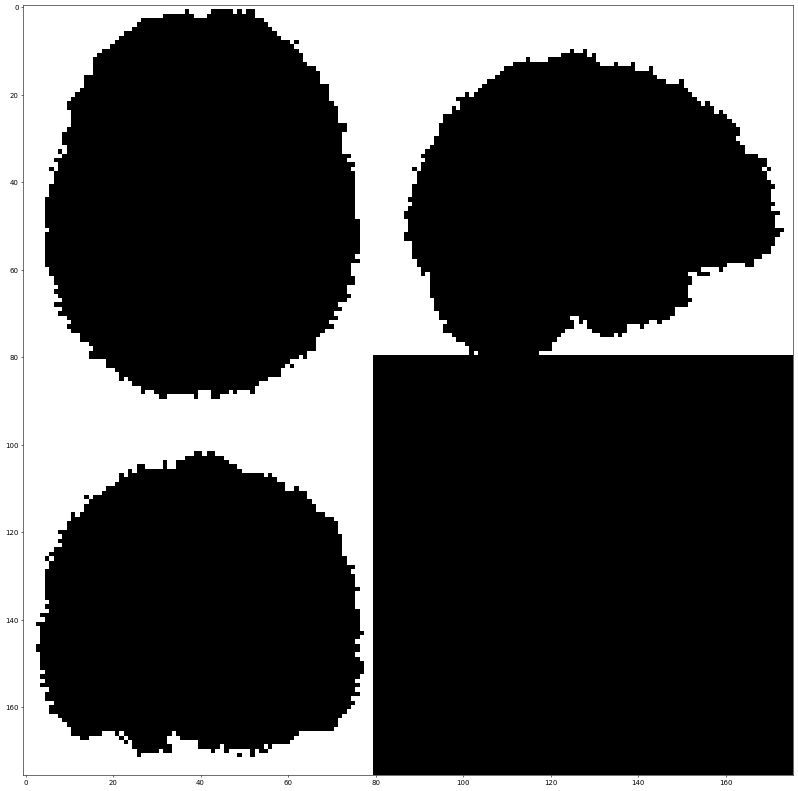

100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


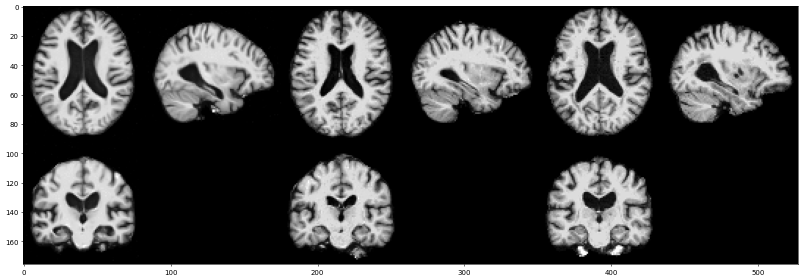

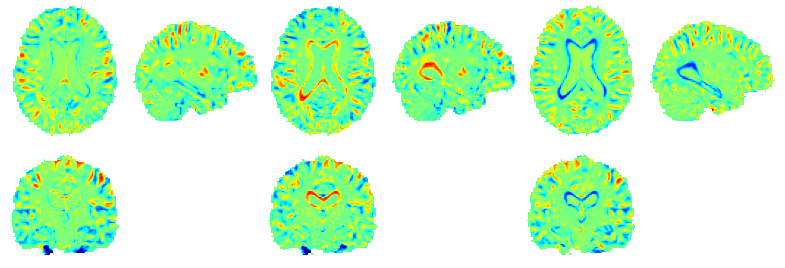

In [5]:
import monai.transforms as mt
mask_t=mt.Compose([
    mt.Lambda(func=lambda x: x <= 0),
    mt.FillHoles(),
    mt.RemoveSmallObjects(),
    mt.KeepLargestConnectedComponent(),
])
batch=next(iter(train_loader))
org = batch['image'].to(device)
lbl = batch['class'].item()
ids = batch['subject_id'][0]
results=[]
mask=mask_t(org)
compare_3d([mask])
for gs in [4]:
    cfg = show_ref_cfg(org, y=3-lbl, guidance_scale=gs )
    tar = show_ref_cfg(org ,y=lbl,guidance_scale=gs )
    cfg=hist_match(cfg,org)
    tar=hist_match(tar,org)
    compare_3d([cfg,tar,org])
    results.append(compare_3d_jet_no_bg([cfg-org,tar-org,cfg-tar],mask))


In [1]:
import monai
import torch
def foo(x, y):
    a = torch.sin(x)
    b = torch.cos(y)
    return a + b
torch.__version__,monai.__version__,torch.compile(foo)

('2.0.1+cu117', '1.2.0', <function __main__.foo(x, y)>)

## [TODO] maybe faster inference?

In [15]:
import torch

#torch._inductor.config.conv_1x1_as_mm = True
#torch._inductor.config.coordinate_descent_tuning = True
#torch._inductor.config.epilogue_fusion = False
#torch._inductor.config.coordinate_descent_check_all_directions = True

model=get_model_by_factor(style_cfg)
model=torch.compile(model, mode="max-autotune", fullgraph=True)

def show_ref_cfg(img,y=1,guidance_scale=3,style_cfg=0.5): 
    current_img = torch.randn((1,1,80,96,80)).to(device)
    scheduler = DDIMScheduler(num_train_timesteps=1000, beta_start=0.0005, beta_end=0.0195)
    scheduler.set_timesteps(num_inference_steps=50)
    from tqdm import tqdm
    progress_bar=tqdm(scheduler.timesteps)
    context=torch.cat([-1* torch.ones((1,1,1)).to(device),y* torch.ones((1,1,1)).to(device)],dim=0)
    
    for t in progress_bar:  # go through the noising process
        with autocast(enabled=False):
            with torch.no_grad():
                inputs=torch.cat([current_img]*2)
                model_output = model(inputs, 
                                     timesteps=torch.Tensor((t,)).long().to(current_img.device),
                                     context=context,
                                     ref_x=torch.cat([img]*2).to(device)
                                    )
                noise_uc,noise_c=model_output.chunk(2)
                noise_pred = noise_uc + guidance_scale * (noise_c - noise_uc)
                
        current_img, _ = scheduler.step(noise_pred, t, current_img)
    return current_img

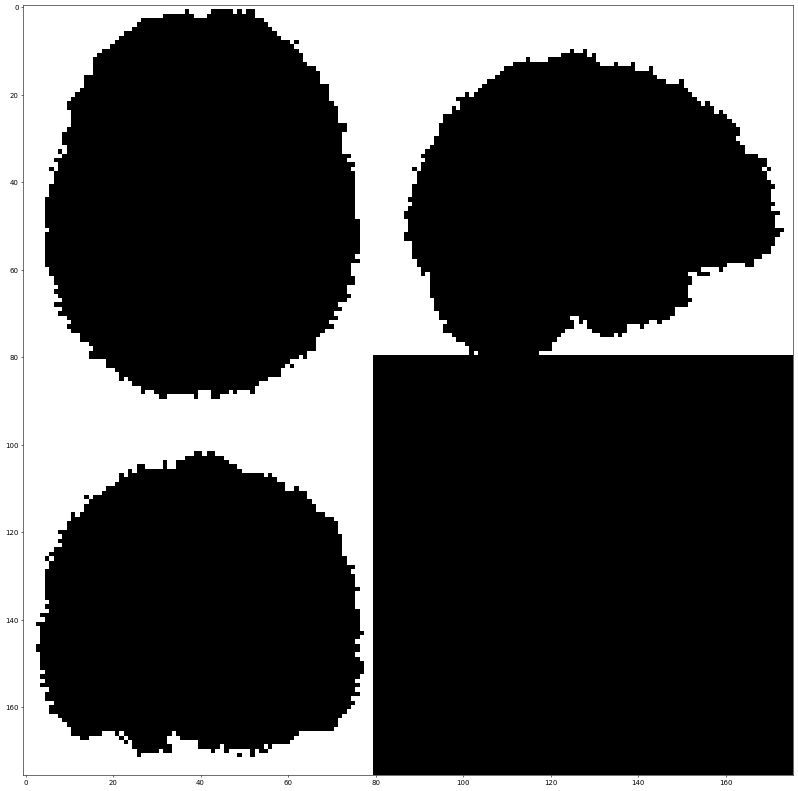

Unsupported: generic_jump TensorVariable()

from user code:
   File "/tmp/ipykernel_518056/543428632.py", line 563, in custom_forward
    if timesteps>stop_t:

Set torch._dynamo.config.verbose=True for more information


You can suppress this exception and fall back to eager by setting:
    torch._dynamo.config.suppress_errors = True


In [17]:
import monai.transforms as mt
mask_t=mt.Compose([
    mt.Lambda(func=lambda x: x <= 0),
    mt.FillHoles(),
    mt.RemoveSmallObjects(),
    mt.KeepLargestConnectedComponent(),
])
batch=next(iter(train_loader))
org = batch['image'].to(device)
lbl = batch['class'].item()
ids = batch['subject_id'][0]
results=[]
mask=mask_t(org)
compare_3d([mask])

model=get_model_by_factor(style_cfg)
model=torch.compile(model, mode="max-autotune", fullgraph=True)
model(org, timesteps=torch.Tensor((0,)).long().to(org.device),context=torch.ones((1,1,1)).to(device),ref_x=torch.cat([org]*2).to(device))

for gs in [4]:
    cfg = show_ref_cfg(org, y=3-lbl, guidance_scale=gs )
    tar = show_ref_cfg(org ,y=lbl,guidance_scale=gs )
    cfg=hist_match(cfg,org)
    tar=hist_match(tar,org)
    compare_3d([cfg,tar,org])
    results.append(compare_3d_jet_no_bg([cfg-org,tar-org,cfg-tar],mask))


In [18]:
model_old=torch.compile(model_old, mode="max-autotune", fullgraph=True)
model_old(org, 
          timesteps=torch.Tensor((0,)).long().to(org.device),
          context=torch.ones((1,1,1)).to(device),
          )

TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
AUTOTUNE bias_addmm(1x256, 1x64, 64x256)
  bias_addmm 0.0043s 100.0%
  addmm 0.0070s 60.5%
  triton_mm_11 0.0072s 59.4%
  triton_mm_9 0.0082s 52.0%
  triton_mm_6 0.0092s 46.2%
  triton_mm_0 0.0102s 41.6%
  triton_mm_5 0.0102s 41.6%
  triton_mm_10 0.0102s 41.6%
  triton_mm_3 0.0103s 41.3%
  triton_mm_8 0.0111s 38.3%
AUTOTUNE bias_addmm(1x256, 1x256, 256x256)
  bias_addmm 0.0051s 100.0%
  addmm 0.0082s 62.5%
  triton_mm_21 0.0133s 38.5%
  triton_mm_23 0.0184s 27.8%
  triton_mm_17 0.0215s 23.8%
  triton_mm_18 0.0215s 23.8%
  triton_mm_12 0.0256s 20.0%
  triton_mm_22 0.0276s 18.5%
  triton_mm_14 0.0287s 17.9%
  triton_mm_15 0.0287s 17.9%
AUTOTUNE bias_addmm(1x64, 1x256, 256x64)
  bias_addmm 0.0051s 100.0%
  addmm 0.0082s 62.5%
  triton_mm_33 0.0133s 38.5%
  triton_mm_35 0.0174s 29.4%
  triton_mm_30 0.0215s 23.8%
  trit

OutOfMemoryError: CUDA out of memory. Tried to allocate 150.00 MiB (GPU 0; 23.65 GiB total capacity; 9.14 GiB already allocated; 146.56 MiB free; 9.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# ilvr

## prepare

In [12]:

import monai.transforms as mt
import monai.data as md
mask_t=mt.Compose([
    mt.Lambda(func=lambda x: x <= 0),
    mt.FillHoles(),
    mt.RemoveSmallObjects(),
    mt.KeepLargestConnectedComponent(),
])

fixed_batch=next(iter(train_loader))
fixed_images=fixed_batch["image"].to(device)
fixed_classes=fixed_batch["class"].to(device)
fixed_context=fixed_classes.unsqueeze(-1).unsqueeze(-1).to(device).float()
fixed_noise=torch.randn_like(fixed_images).to(device)
fixed_classes=fixed_batch["class"].to(device)
fixed_context=fixed_classes.unsqueeze(-1).unsqueeze(-1).to(device).float()
adver_classes=3-fixed_batch["class"].to(device) # 1to2,2to1
adver_context=adver_classes.unsqueeze(-1).unsqueeze(-1).to(device).float()

post_transforms=mt.Compose([
    mt.CopyItemsd(keys="out_image",names="mask"),
    mt.Lambdad(keys="mask",func=lambda x:x>0.1),
    mt.FillHolesd(keys="mask"),
    mt.Lambdad(keys="out_image",func=lambda x:x.clamp(0,1)),
    mt.Lambda(func=lambda x:{"out_image":x["out_image"]*x["mask"]}),
    mt.HistogramNormalized(keys="out_image"),
    mt.ScaleIntensityd(keys="out_image"),
])
fixed_images_post=post_transforms({"out_image":fixed_images})["out_image"]
@torch.no_grad()
def sample_function_ilvr(
    input_noise,
    diffusion_model,
    scheduler,
    conditioning,
    mode,
    ilvr_ref,
    ilvr_n,
    ilvr_end,
    uncond=None,
    guidance_scale=None,
    progress=True,
):
    
    if ilvr_n!=None:
        N=int(ilvr_n)
        in_shape=(2,1,80,96,80)
        output_shape=(2,1,80//N,96//N,80//N)
        down=Resizer(in_shape=in_shape,output_shape=output_shape).to(input_noise.device)
        up=Resizer(in_shape=output_shape,output_shape=in_shape).to(input_noise.device)
        ilvr_refs=torch.tensor(ilvr_ref.cpu().numpy()).to(input_noise.device)
    
    
    if uncond==None:
        uncond=-1.0*torch.ones_like(conditioning)
    if guidance_scale==None:
        guidance_scale=3.0
    
    scheduler.set_timesteps(num_inference_steps=50)
    from tqdm import tqdm
    if progress:
        progress_bar = tqdm(scheduler.timesteps,position=0, leave=True)
    else:
        progress_bar = iter(scheduler.timesteps)
    image=torch.tensor(input_noise.cpu().numpy()).to(ilvr_refs.device)
    for t in progress_bar:
        with autocast(enabled=True):
            if t>ilvr_end:
                noisy_ref = scheduler.add_noise(ilvr_refs, noise=torch.randn_like(ilvr_refs), timesteps=t)
                image=image-up(down(image))+up(down(noisy_ref))
            if mode == "concat":
                model_input = torch.cat([image, conditioning], dim=1)
                model_output = diffusion_model(
                    model_input, timesteps=torch.Tensor((t,)).to(input_noise.device), context=None
                )
            else:
                model_input = torch.cat([image]*2,dim=0)
                context=torch.cat([uncond,conditioning],dim=0)
                #print(model_input.shape,conditioning.shape)
                noise_uc,noise_c=diffusion_model(
                    model_input, timesteps=torch.Tensor((t,)).to(input_noise.device), context=context
                ).chunk(2)
                model_output=noise_uc + guidance_scale*(noise_c - noise_uc)
        image, _ = scheduler.step(model_output, t, image)
    if progress:
        progress_bar.close()
    return image
import numpy as np
import torch
from math import pi
from torch import nn


class Resizer(nn.Module):
    def __init__(self, in_shape, scale_factor=None, output_shape=None, kernel=None, antialiasing=True):
        super(Resizer, self).__init__()

        # First standardize values and fill missing arguments (if needed) by deriving scale from output shape or vice versa
        scale_factor, output_shape = self.fix_scale_and_size(in_shape, output_shape, scale_factor)

        # Choose interpolation method, each method has the matching kernel size
        method, kernel_width = {
            "cubic": (cubic, 4.0),
            "lanczos2": (lanczos2, 4.0),
            "lanczos3": (lanczos3, 6.0),
            "box": (box, 1.0),
            "linear": (linear, 2.0),
            None: (cubic, 4.0)  # set default interpolation method as cubic
        }.get(kernel)

        # Antialiasing is only used when downscaling
        antialiasing *= (np.any(np.array(scale_factor) < 1))

        # Sort indices of dimensions according to scale of each dimension. since we are going dim by dim this is efficient
        sorted_dims = np.argsort(np.array(scale_factor))
        self.sorted_dims = [int(dim) for dim in sorted_dims if scale_factor[dim] != 1]

        # Iterate over dimensions to calculate local weights for resizing and resize each time in one direction
        field_of_view_list = []
        weights_list = []
        for dim in self.sorted_dims:
            # for each coordinate (along 1 dim), calculate which coordinates in the input image affect its result and the
            # weights that multiply the values there to get its result.
            weights, field_of_view = self.contributions(in_shape[dim], output_shape[dim], scale_factor[dim], method,
                                                        kernel_width, antialiasing)

            # convert to torch tensor
            weights = torch.tensor(weights.T, dtype=torch.float32)

            # We add singleton dimensions to the weight matrix so we can multiply it with the big tensor we get for
            # tmp_im[field_of_view.T], (bsxfun style)
            weights_list.append(
                nn.Parameter(torch.reshape(weights, list(weights.shape) + (len(scale_factor) - 1) * [1]),
                             requires_grad=False))
            field_of_view_list.append(
                nn.Parameter(torch.tensor(field_of_view.T.astype(np.int32), dtype=torch.long), requires_grad=False))

        self.field_of_view = nn.ParameterList(field_of_view_list)
        self.weights = nn.ParameterList(weights_list)

    def forward(self, in_tensor):
        x = in_tensor

        # Use the affecting position values and the set of weights to calculate the result of resizing along this 1 dim
        for dim, fov, w in zip(self.sorted_dims, self.field_of_view, self.weights):
            # To be able to act on each dim, we swap so that dim 0 is the wanted dim to resize
            x = torch.transpose(x, dim, 0)

            # This is a bit of a complicated multiplication: x[field_of_view.T] is a tensor of order image_dims+1.
            # for each pixel in the output-image it matches the positions the influence it from the input image (along 1 dim
            # only, this is why it only adds 1 dim to 5the shape). We then multiply, for each pixel, its set of positions with
            # the matching set of weights. we do this by this big tensor element-wise multiplication (MATLAB bsxfun style:
            # matching dims are multiplied element-wise while singletons mean that the matching dim is all multiplied by the
            # same number
            x = torch.sum(x[fov] * w, dim=0)

            # Finally we swap back the axes to the original order
            x = torch.transpose(x, dim, 0)

        return x

    def fix_scale_and_size(self, input_shape, output_shape, scale_factor):
        # First fixing the scale-factor (if given) to be standardized the function expects (a list of scale factors in the
        # same size as the number of input dimensions)
        if scale_factor is not None:
            # By default, if scale-factor is a scalar we assume 2d resizing and duplicate it.
            if np.isscalar(scale_factor) and len(input_shape) > 1:
                scale_factor = [scale_factor, scale_factor]

            # We extend the size of scale-factor list to the size of the input by assigning 1 to all the unspecified scales
            scale_factor = list(scale_factor)
            scale_factor = [1] * (len(input_shape) - len(scale_factor)) + scale_factor

        # Fixing output-shape (if given): extending it to the size of the input-shape, by assigning the original input-size
        # to all the unspecified dimensions
        if output_shape is not None:
            output_shape = list(input_shape[len(output_shape):]) + list(np.uint(np.array(output_shape)))

        # Dealing with the case of non-give scale-factor, calculating according to output-shape. note that this is
        # sub-optimal, because there can be different scales to the same output-shape.
        if scale_factor is None:
            scale_factor = 1.0 * np.array(output_shape) / np.array(input_shape)

        # Dealing with missing output-shape. calculating according to scale-factor
        if output_shape is None:
            output_shape = np.uint(np.ceil(np.array(input_shape) * np.array(scale_factor)))

        return scale_factor, output_shape

    def contributions(self, in_length, out_length, scale, kernel, kernel_width, antialiasing):
        # This function calculates a set of 'filters' and a set of field_of_view that will later on be applied
        # such that each position from the field_of_view will be multiplied with a matching filter from the
        # 'weights' based on the interpolation method and the distance of the sub-pixel location from the pixel centers
        # around it. This is only done for one dimension of the image.

        # When anti-aliasing is activated (default and only for downscaling) the receptive field is stretched to size of
        # 1/sf. this means filtering is more 'low-pass filter'.
        fixed_kernel = (lambda arg: scale * kernel(scale * arg)) if antialiasing else kernel
        kernel_width *= 1.0 / scale if antialiasing else 1.0

        # These are the coordinates of the output image
        out_coordinates = np.arange(1, out_length + 1)

        # since both scale-factor and output size can be provided simulatneously, perserving the center of the image requires shifting
        # the output coordinates. the deviation is because out_length doesn't necesary equal in_length*scale.
        # to keep the center we need to subtract half of this deivation so that we get equal margins for boths sides and center is preserved.
        shifted_out_coordinates = out_coordinates - (out_length - in_length * scale) / 2

        # These are the matching positions of the output-coordinates on the input image coordinates.
        # Best explained by example: say we have 4 horizontal pixels for HR and we downscale by SF=2 and get 2 pixels:
        # [1,2,3,4] -> [1,2]. Remember each pixel number is the middle of the pixel.
        # The scaling is done between the distances and not pixel numbers (the right boundary of pixel 4 is transformed to
        # the right boundary of pixel 2. pixel 1 in the small image matches the boundary between pixels 1 and 2 in the big
        # one and not to pixel 2. This means the position is not just multiplication of the old pos by scale-factor).
        # So if we measure distance from the left border, middle of pixel 1 is at distance d=0.5, border between 1 and 2 is
        # at d=1, and so on (d = p - 0.5).  we calculate (d_new = d_old / sf) which means:
        # (p_new-0.5 = (p_old-0.5) / sf)     ->          p_new = p_old/sf + 0.5 * (1-1/sf)
        match_coordinates = shifted_out_coordinates / scale + 0.5 * (1 - 1 / scale)

        # This is the left boundary to start multiplying the filter from, it depends on the size of the filter
        left_boundary = np.floor(match_coordinates - kernel_width / 2)

        # Kernel width needs to be enlarged because when covering has sub-pixel borders, it must 'see' the pixel centers
        # of the pixels it only covered a part from. So we add one pixel at each side to consider (weights can zeroize them)
        expanded_kernel_width = np.ceil(kernel_width) + 2

        # Determine a set of field_of_view for each each output position, these are the pixels in the input image
        # that the pixel in the output image 'sees'. We get a matrix whos horizontal dim is the output pixels (big) and the
        # vertical dim is the pixels it 'sees' (kernel_size + 2)
        field_of_view = np.squeeze(
            np.int16(np.expand_dims(left_boundary, axis=1) + np.arange(expanded_kernel_width) - 1))

        # Assign weight to each pixel in the field of view. A matrix whos horizontal dim is the output pixels and the
        # vertical dim is a list of weights matching to the pixel in the field of view (that are specified in
        # 'field_of_view')
        weights = fixed_kernel(1.0 * np.expand_dims(match_coordinates, axis=1) - field_of_view - 1)

        # Normalize weights to sum up to 1. be careful from dividing by 0
        sum_weights = np.sum(weights, axis=1)
        sum_weights[sum_weights == 0] = 1.0
        weights = 1.0 * weights / np.expand_dims(sum_weights, axis=1)

        # We use this mirror structure as a trick for reflection padding at the boundaries
        mirror = np.uint(np.concatenate((np.arange(in_length), np.arange(in_length - 1, -1, step=-1))))
        field_of_view = mirror[np.mod(field_of_view, mirror.shape[0])]

        # Get rid of  weights and pixel positions that are of zero weight
        non_zero_out_pixels = np.nonzero(np.any(weights, axis=0))
        weights = np.squeeze(weights[:, non_zero_out_pixels])
        field_of_view = np.squeeze(field_of_view[:, non_zero_out_pixels])

        # Final products are the relative positions and the matching weights, both are output_size X fixed_kernel_size
        return weights, field_of_view


# These next functions are all interpolation methods. x is the distance from the left pixel center


def cubic(x):
    absx = np.abs(x)
    absx2 = absx ** 2
    absx3 = absx ** 3
    return ((1.5 * absx3 - 2.5 * absx2 + 1) * (absx <= 1) +
            (-0.5 * absx3 + 2.5 * absx2 - 4 * absx + 2) * ((1 < absx) & (absx <= 2)))


def lanczos2(x):
    return (((np.sin(pi * x) * np.sin(pi * x / 2) + np.finfo(np.float32).eps) /
             ((pi ** 2 * x ** 2 / 2) + np.finfo(np.float32).eps))
            * (abs(x) < 2))


def box(x):
    return ((-0.5 <= x) & (x < 0.5)) * 1.0


def lanczos3(x):
    return (((np.sin(pi * x) * np.sin(pi * x / 3) + np.finfo(np.float32).eps) /
             ((pi ** 2 * x ** 2 / 3) + np.finfo(np.float32).eps))
            * (abs(x) < 3))


def linear(x):
    return (x + 1) * ((-1 <= x) & (x < 0)) + (1 - x) * ((0 <= x) & (x <= 1))


In [13]:
def compare_3d(image_list):
    def show_3d(image):
        _,_,h,w,d=image.shape
        plotting_image_0 = np.concatenate([np.fliplr(image[0, 0, :, :, d//2].cpu()), np.fliplr(image[0, 0, :, w//2, :].cpu())], axis=1)
        plotting_image_1 = np.concatenate([np.fliplr(image[0, 0, int(0.3*h), :, :].cpu()), np.zeros((w, w))], axis=1)
        return np.concatenate([plotting_image_0, plotting_image_1],axis=0).T
    plt.figure(figsize=(20,20),dpi=50)
    plt.imshow(np.concatenate([show_3d(image) for image in image_list], axis=1), 
               cmap="gray",vmin=0,vmax=1)
    plt.axis("off")
    plt.show()
def compare_3d_jet(image_list):
    def show_3d(image):
        _,_,h,w,d=image.shape
        plotting_image_0 = np.concatenate([np.fliplr(image[0, 0, :, :, d//2].cpu()), np.fliplr(image[0, 0, :, w//2, :].cpu())], axis=1)
        plotting_image_1 = np.concatenate([np.fliplr(image[0, 0, int(0.3*h), :, :].cpu()), np.zeros((w, w))], axis=1)
        return np.concatenate([plotting_image_0, plotting_image_1],axis=0).T
    plt.figure(figsize=(20,20),dpi=50)
    plt.imshow(np.concatenate([show_3d(image) for image in image_list], axis=1), 
               cmap="jet",vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()
def compare_3d_jet_no_bg(image_list,mask):
    def show_3d(image,mask):
        _,_,h,w,d=image.shape
        image=image.cpu().numpy()
        mask=mask.cpu().numpy()
        image[mask]=np.Inf
        plotting_image_0 = np.concatenate([np.fliplr(image[0, 0, :, :, d//2]), np.fliplr(image[0, 0, :, w//2, :])], axis=1)
        plotting_image_1 = np.concatenate([np.fliplr(image[0, 0, int(0.3*h), :, :]), np.Inf*np.ones((w, w))], axis=1)
        return np.concatenate([plotting_image_0, plotting_image_1],axis=0).T
    plt.figure(figsize=(20,20),dpi=50)
    # jet cmap
    cmap=plt.cm.jet
    # set NaN to red
    cmap.set_bad(color="white")
    plt.imshow(np.concatenate([show_3d(image,mask) for image in image_list], axis=1),
               cmap=cmap,vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()

## generations

In [ ]:
#fixed_batch=next(iter(train_loader))
from tqdm import tqdm
for fixed_batch in tqdm(train_loader,total=len(train_loader)):
    fixed_images=fixed_batch["image"].to(device)
    fixed_classes=fixed_batch["class"].to(device)
    fixed_context=fixed_classes.unsqueeze(-1).unsqueeze(-1).to(device).float()
    fixed_noise=torch.randn_like(fixed_images).to(device)
    fixed_classes=fixed_batch["class"].to(device)
    fixed_context=fixed_classes.unsqueeze(-1).unsqueeze(-1).to(device).float()
    adver_classes=3-fixed_batch["class"].to(device) # 1to2,2to1
    adver_context=adver_classes.unsqueeze(-1).unsqueeze(-1).to(device).float()

    for n in [2,4,8,16]:
        result_list=[fixed_images_post,]
        diff_list=[torch.zeros_like(fixed_images_post)]

        mask=mask_t(fixed_images_post)
        for ilvr_end in [250,500,750,1000]:
            if os.path.exists(os.path.join("out",f"ilvr_n{n}",f"ilvr_end{ilvr_end}",fixed_batch["subject_id"][0],)):
                continue
            out=sample_function_ilvr(fixed_noise,model_old,scheduler,ilvr_n=n,ilvr_end=ilvr_end,ilvr_ref=fixed_images,
                                     conditioning=adver_context,#fixed_context,#adver_context
                                     mode="crossattn",progress=False)
            mt.SaveImage(output_dir=os.path.join("out",f"ilvr_n{n}",f"ilvr_end{ilvr_end}",fixed_batch["subject_id"][0]),
                         output_postfix="ilvr",separate_folder=False)(out.squeeze(0))
            out_data={"out_image":out}
            fixed_images_post=post_transforms({"out_image":fixed_images})["out_image"]
            out_image_post=post_transforms(out_data)["out_image"]
            result_list.append(out_image_post)
            diff_list.append(fixed_images_post-out_image_post)
        #compare_3d(result_list)
        #compare_3d_jet_no_bg(diff_list,mask)

 28%|██▊       | 120/431 [01:10<03:07,  1.66it/s]monai.transforms.io.array SaveImage.__init__:resample: Current default value of argument `resample=True` has been deprecated since version 1.1. It will be changed to `resample=False` in version 1.3.


2024-01-21 23:20:59,297 INFO image_writer.py:197 - writing: out/ilvr_n8/ilvr_end500/037_S_0627/0_ilvr.nii.gz
2024-01-21 23:21:20,154 INFO image_writer.py:197 - writing: out/ilvr_n8/ilvr_end750/037_S_0627/0_ilvr.nii.gz
2024-01-21 23:21:42,392 INFO image_writer.py:197 - writing: out/ilvr_n8/ilvr_end1000/037_S_0627/0_ilvr.nii.gz
2024-01-21 23:22:04,916 INFO image_writer.py:197 - writing: out/ilvr_n16/ilvr_end250/037_S_0627/0_ilvr.nii.gz
2024-01-21 23:22:27,047 INFO image_writer.py:197 - writing: out/ilvr_n16/ilvr_end500/037_S_0627/0_ilvr.nii.gz
2024-01-21 23:22:48,972 INFO image_writer.py:197 - writing: out/ilvr_n16/ilvr_end750/037_S_0627/0_ilvr.nii.gz
2024-01-21 23:23:11,443 INFO image_writer.py:197 - writing: out/ilvr_n16/ilvr_end1000/037_S_0627/0_ilvr.nii.gz


 28%|██▊       | 121/431 [03:44<4:00:50, 46.61s/it]

2024-01-21 23:23:35,587 INFO image_writer.py:197 - writing: out/ilvr_n2/ilvr_end250/041_S_1391/0_ilvr.nii.gz


In [63]:
mt.SaveImage(output_dir=os.path.join("out",f"ilvr_n{n}",f"ilvr_end{ilvr_end}",fixed_batch["subject_id"][0]),
             output_postfix="ivlr",separate_folder=False)(out.squeeze(0))

2024-01-20 15:41:51,617 INFO image_writer.py:197 - writing: out/ilvr_n2/ilvr_end750/141_S_1094/0_ivlr.nii.gz


tensor([[[[-8.8147e-03, -2.9841e-03,  4.3025e-03,  ...,  1.0062e-03,
           -3.0224e-04,  7.7661e-04],
          [-5.7531e-03, -2.3467e-04,  8.4349e-03,  ..., -2.0305e-03,
            1.1484e-02,  1.5898e-03],
          [-1.1322e-03,  1.3857e-02,  7.8285e-04,  ...,  1.1293e-02,
            6.4116e-03,  2.9023e-03],
          ...,
          [-2.5862e-03,  4.0123e-03, -4.5957e-03,  ...,  9.8696e-03,
           -4.0922e-03,  2.6504e-03],
          [ 1.5843e-03,  7.6829e-04,  1.9183e-03,  ...,  2.2542e-03,
           -3.4800e-03, -3.6962e-04],
          [-4.5394e-03, -6.3426e-03, -3.2558e-03,  ..., -4.4711e-03,
            1.7883e-04, -2.5455e-03]],

         [[-3.1400e-03,  1.2663e-02, -7.2831e-03,  ...,  4.6934e-03,
           -2.5534e-04, -1.3612e-03],
          [-5.3447e-03,  7.8044e-03,  3.9507e-03,  ...,  7.1402e-03,
            1.0457e-02, -1.8730e-03],
          [ 2.7047e-03,  3.4391e-03,  3.5526e-03,  ...,  4.2888e-03,
            5.1629e-03,  2.1850e-03],
          ...,
     

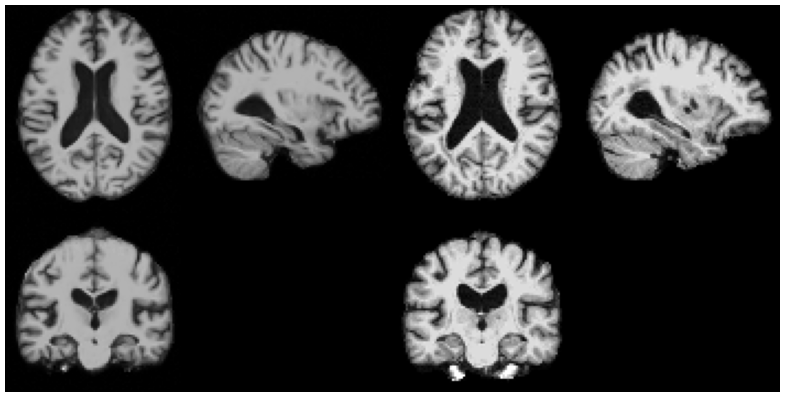

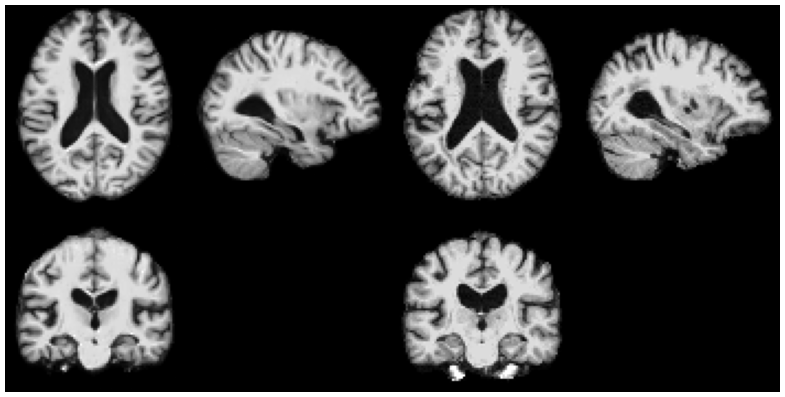

In [8]:
def hist_match(source,target):
    oldshape=source.shape
    source=source.view(-1).cpu().numpy()
    target=target.view(-1).cpu().numpy()
    # transform source form [0,1] to [0,255] integer
    source=[int(i*255) for i in source]
    target=[int(i*255) for i in target]
    s_values,bin_idx,s_counts=np.unique(source,return_inverse=True,return_counts=True)
    t_values,t_counts=np.unique(target,return_counts=True)
    s_quantiles=np.cumsum(s_counts).astype(np.float64)
    s_quantiles/=s_quantiles[-1]
    t_quantiles=np.cumsum(t_counts).astype(np.float64)
    t_quantiles/=t_quantiles[-1]
    interp_t_values=np.interp(s_quantiles,t_quantiles,t_values)
    result=interp_t_values[bin_idx].reshape(oldshape)/255
    return torch.from_numpy(result).float().cuda()
compare_3d([out,fixed_images])
out_hist=hist_match(out,fixed_images)
compare_3d([out_hist,fixed_images])

In [40]:
import monai.metrics as mm
import generative.metrics as gm

m=mm.SSIMMetric(spatial_dims=3,data_range= 1.0,win_size=4)
#m=mm.PSNRMetric(max_val=1.0)
#m=gm.MultiScaleSSIMMetric(spatial_dims=3,data_range= 1.0,kernel_size=4)
u = torch.nn.Upsample(size=(160,192,160), mode='trilinear')
x,y=out_hist,fixed_images
#x,y=out_image_post,fixed_images_post
uout=u(x)
uorg=u(y)

m(uout,uorg)

tensor([[0.7337]], device='cuda:0')

100%|██████████| 50/50 [00:24<00:00,  2.08it/s]


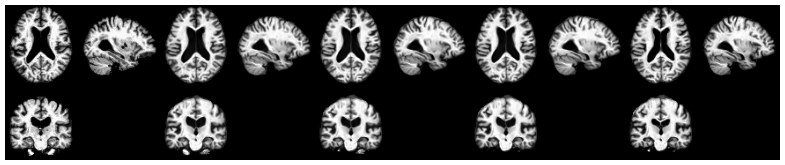

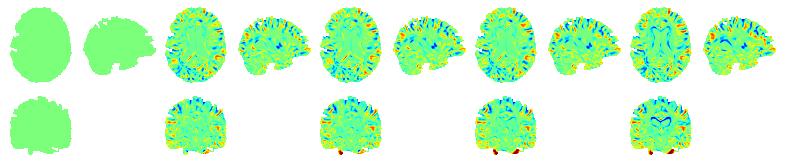

In [42]:
out_list=[]
fixed_images_post=post_transforms({"out_image":fixed_images})["out_image"]
for n in [4]:
    result_list=[fixed_images_post,]
    diff_list=[torch.zeros_like(fixed_images_post)]

    mask=mask_t(fixed_images_post)
    for ilvr_end in [250,500,750,1000]:
        out=sample_function_ilvr(fixed_noise,model_old,scheduler,ilvr_n=n,ilvr_end=ilvr_end,ilvr_ref=fixed_images,
                                 conditioning=adver_context,#fixed_context,#adver_context
                                 mode="crossattn")
        out_list.append(out)
        out_data={"out_image":out}
        out_image_post=post_transforms(out_data)["out_image"]
        result_list.append(out_image_post)
        diff_list.append(fixed_images_post-out_image_post)
    compare_3d(result_list)
    compare_3d_jet_no_bg(diff_list,mask)

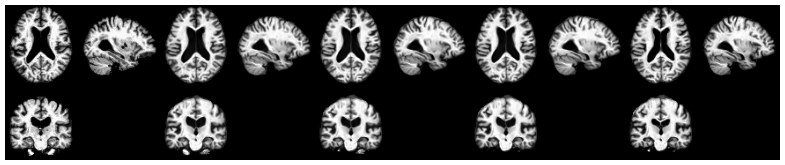

array([[1.        , 0.74938107, 0.73304319, 0.72929859, 0.71886772],
       [0.74938107, 1.        , 0.96297765, 0.95166445, 0.92155641],
       [0.73304319, 0.96297765, 1.        , 0.97286749, 0.93976015],
       [0.72929859, 0.95166445, 0.97286749, 1.        , 0.94342589],
       [0.71886772, 0.92155641, 0.93976015, 0.94342589, 1.        ]])

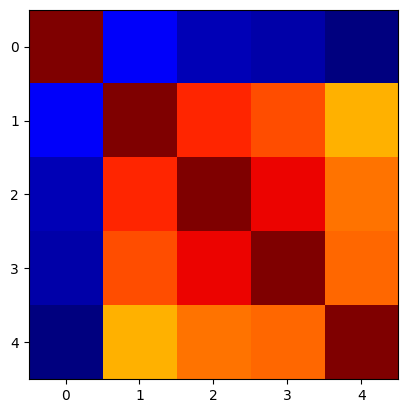

In [51]:
compare_3d(result_list)
import monai.metrics as mm
import generative.metrics as gm

m=mm.SSIMMetric(spatial_dims=3,data_range= 1.0,win_size=4)
#m=mm.PSNRMetric(max_val=1.0)
#m=gm.MultiScaleSSIMMetric(spatial_dims=3,data_range= 1.0,kernel_size=4)
show=np.zeros([len(result_list),len(result_list)])
u = torch.nn.Upsample(size=(160,192,160), mode='trilinear')
for i,x in enumerate(result_list):
    for j,y in enumerate(result_list):
        uout=u(x)
        uorg=u(y)

        show[i,j]=m(uout,uorg)
plt.imshow(show,"jet")
show

## [TODO] maybe faster inference?

# DDIM

## prepare

In [ ]:
@torch.no_grad()
def sample_function_inversion(
    diffusion_model,
    scheduler,
    conditioning,
    mode,
    input_noise=None,
    rev_x=None,
    rev_depth=None,
    rev_context=None,
    uncond=None,
    guidance_scale=None
):
    if uncond==None:
        uncond=-1.0*torch.ones_like(conditioning)
    if guidance_scale==None:
        guidance_scale=3.0
    if rev_x==None or input_noise!=None:
        print("ref_x must exist and input_noise must be None")
        return 0
    if rev_context==None:
        rev_context=uncond
    scheduler.set_timesteps(num_inference_steps=50)
    scheduler.clip_sample = False # specific for ddim
    
    from tqdm import tqdm
    progress_bar = tqdm(scheduler.timesteps,position=0, leave=True)
    #image=input_noise
    image=rev_x
    
    device=rev_x.device
    for t in progress_bar:
        with autocast(enabled=True):
            t=1000-t-1
            if t<rev_depth:
                model_output = diffusion_model(image, timesteps=torch.Tensor((t,)).to(device), context=rev_context)
                image, _ = scheduler.reversed_step(model_output, t, image)
    latent_img=image
    
    progress_bar = tqdm(scheduler.timesteps,position=0, leave=True)
    for t in progress_bar:
        if t<=rev_depth:
            with autocast(enabled=True):
                if mode == "concat":
                    model_input = torch.cat([image, conditioning], dim=1)
                    model_output = diffusion_model(
                        model_input, timesteps=torch.Tensor((t,)).to(device), context=None
                    )
                else:
                    model_input = torch.cat([image]*2,dim=0)
                    context=torch.cat([uncond,conditioning],dim=0)
                    #print(model_input.shape,conditioning.shape)
                    noise_uc,noise_c=diffusion_model(
                        model_input, timesteps=torch.Tensor((t,)).to(device), context=context
                    ).chunk(2)
                    model_output=noise_uc + guidance_scale*(noise_c-noise_uc)
            image, _ = scheduler.step(model_output, t, image)
    torch.cuda.empty_cache()
    return image,latent_img


## genertions

In [ ]:


fixed_images_post=post_transforms({"out_image":fixed_images})["out_image"]
fixed_result=sample_function_inversion(model_old,scheduler,
                                 rev_x=fixed_images,rev_depth=500,rev_context=fixed_context,
                                 conditioning=fixed_context,
                                 guidance_scale=7.0,
                                 mode="crossattn")
adver_result=sample_function_inversion(model_old,scheduler,
                                 rev_x=fixed_images,rev_depth=500,rev_context=fixed_context,
                                 conditioning=adver_context,
                                 guidance_scale=7.0,
                                 #fixed_context,#adver_context
                                 mode="crossattn")
fixed_out_data={"out_image":fixed_result[0]}
fixed_out_image_post=post_transforms(fixed_out_data)["out_image"]
adver_out_data={"out_image":adver_result[0]}
adver_out_image_post=post_transforms(adver_out_data)["out_image"]

mask=mask_t(fixed_images_post)
compare_3d([fixed_images_post,fixed_out_image_post,adver_out_image_post])
compare_3d_jet_no_bg([fixed_images_post-fixed_out_image_post,
                fixed_images_post-adver_out_image_post,
                fixed_out_image_post-adver_out_image_post],mask)







fixed_images_post=post_transforms({"out_image":fixed_images})["out_image"]
fixed_result=sample_function_inversion(model_old,scheduler,
                                 rev_x=fixed_images,rev_depth=500,rev_context=adver_context,
                                 conditioning=fixed_context,
                                 guidance_scale=7.0,
                                 mode="crossattn")
adver_result=sample_function_inversion(model_old,scheduler,
                                 rev_x=fixed_images,rev_depth=500,rev_context=adver_context,
                                 conditioning=adver_context,
                                 guidance_scale=7.0,
                                 #fixed_context,#adver_context
                                 mode="crossattn")
fixed_out_data={"out_image":fixed_result[0]}
fixed_out_image_post=post_transforms(fixed_out_data)["out_image"]
adver_out_data={"out_image":adver_result[0]}
adver_out_image_post=post_transforms(adver_out_data)["out_image"]

mask=mask_t(fixed_images_post)
compare_3d([fixed_images_post,fixed_out_image_post,adver_out_image_post])
compare_3d_jet_no_bg([fixed_images_post-fixed_out_image_post,
                fixed_images_post-adver_out_image_post,
                fixed_out_image_post-adver_out_image_post],mask)